**CHEST X-RAY IMAGE CLASSIFICATION ADVANCED DATA SCIENCE CAPSTONE PROJECT**

Paolo Cavadini, February 2021.

Dataset
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [1]:
import os

import keras
from keras.preprocessing import image
from keras import backend as K
from keras.models import Sequential, load_model
from keras import layers
from keras.layers import Input, Dense, Dropout, Flatten, MaxPool2D 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D 
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping 
import itertools
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score 
import seaborn as sns
import tensorflow as tf

**DATA ETL**

**Read scans from the file system and encode the labels.**

In [2]:
def get_path(PATH):
    '''
    This function stores the file paths and the labels for normal and pneumonia images
    '''
    try:
        #saving jpeg only image paths in lists for nromal and penumonia
        paths_norm = [PATH + 'norm/' + p for p in os.listdir(PATH + 'norm/') if p.endswith('.jpeg')] #reads file paths
        paths_pneu = [PATH + 'pneu/' + p for p in os.listdir(PATH + 'pneu/') if p.endswith('.jpeg')] #reads file paths
        #persisting the correspondent class labels
        labels_norm = [0 for i in paths_norm]
        labels_pneu = [1 for i in paths_pneu]
    except Exception as e:
        print(e)
    return paths_norm, paths_pneu, labels_norm, labels_pneu

In [3]:
PATH = "./data/"
n, p, ln, lp = get_path(PATH)

**Loading images and transforming into arrays.**

In [4]:
# Setting the image size
IMAGE_SIZE = (150,150)

In [11]:
# Loading images using Keras preprocessing.

try:
    imgs_n = [image.load_img(img_path, target_size=(IMAGE_SIZE), color_mode='rgb') for img_path in n] ## rgb scale
    imgs_p = [image.load_img(img_path, target_size=(IMAGE_SIZE), color_mode='rgb') for img_path in p] 
    xn = np.array([image.img_to_array(img, data_format='channels_last') for img in imgs_n]) # channel last
    xp = np.array([image.img_to_array(img, data_format='channels_last') for img in imgs_p])
except Exception as e:
    print(e)

print(xn.shape, xp.shape)

(1583, 150, 150, 3) (4273, 150, 150, 3)


In [12]:
# Merging the features and the class labels of the scans with a without pneumonia.

X = np.vstack((xn, xp))
Y = np.vstack((np.reshape(np.array(ln),(-1,1)), np.reshape(np.array(lp),(-1,1))))
print(X.shape, Y.shape)

(5856, 150, 150, 3) (5856, 1)


In [13]:
np.save('./data/X.npy', X)
np.save('./data/Y.npy', Y)

In [14]:
# X = np.load('./data/X.npy')
# Y = np.load('./data/Y.npy')

**DATA EXPLORATION**

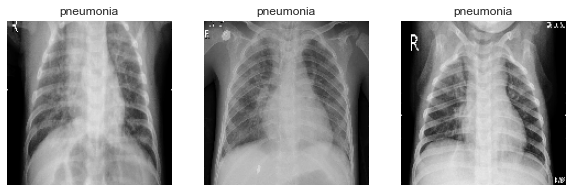

In [15]:
# Visualizing random images from train samples.

plt.figure(figsize=(10,10))
for i in range(1,4):
    plt.subplot(1,3,i)
    random_num = np.random.randint(0,len(X))
    plt.imshow(X[random_num][:,:,:]/255) # normalizing
    plt.grid(False)
    plt.axis('off')
    plt.title('pneumonia' if Y[random_num] == 1 else 'normal')
plt.show()

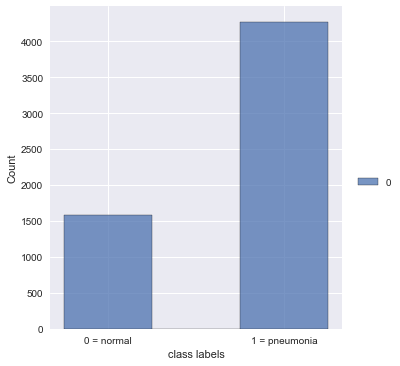

In [16]:
# Distribution of the labels.

fg = sns.displot(data=Y, binwidth=0.4)
fg.ax.set_xticks([0.2,1])
fg.ax.set_xticklabels(['0 = normal','1 = pneumonia'])
fg.ax.set_xlabel('class labels')
plt.show()

0.0 255.0


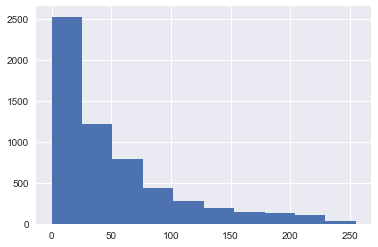

In [17]:
# Distribution of the data along the first dimension.

print(X[:,0,0,0].min(), X[:,0,0,0].max())
plt.hist(X[:,0,0,0])
plt.show()

In [18]:
# Picking a random scan.

random_num = np.random.randint(0,len(X))

0.0 132.0


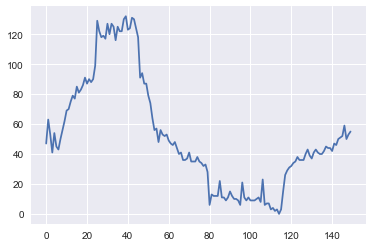

In [19]:
# Distribution of the data along the second dimension for the selected scan.

print(X[random_num,:,0,0].min(), X[random_num,:,0,0].max())
plt.plot(X[random_num,:,0,0])
plt.show()

8.0 190.0


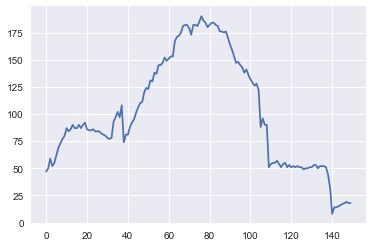

In [20]:
# Distribution of the data along the third dimension for the selected scan.

print(X[random_num,0,:,0].min(), X[random_num,0,:,0].max())
plt.plot(X[random_num,0,:,0])
plt.show()

In [21]:
# Min and Max for the last dimension for the selected scan.

print(X[random_num,0,0,:].min(), X[random_num,0,0,:].max())

47.0 47.0


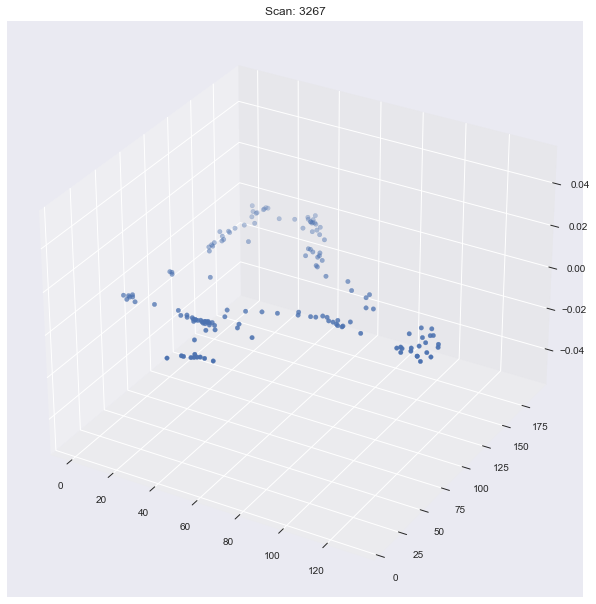

In [22]:
# 3D representation of the selected scan.

fig = plt.figure(figsize=(16,8))
ax = Axes3D(fig)

ax.scatter(xs=X[random_num][:,0,0], ys=X[random_num][0,:,0], marker='o')
ax.set_title('Scan: ' + str(random_num))
plt.show()

**FEATURE ENGINEERING**

**Reshape the images based on channel**

In [24]:
img_rows, img_cols = IMAGE_SIZE
if K.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X = X.reshape(X.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)
print(X.shape)

(5856, 150, 150, 3)


**Normalizing**

In [25]:
# Divide by 255 to obtain an array of values between 0 and 1 which will be digested by the algorithm.

X = X/255

**Casting**

In [26]:
X = X.astype('float32')
Y = Y.astype('float32')

**Train-test split**

In [27]:
# Using sci-kit learn train test split to obtain the training (80%) and the test set (20%).

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
print(
    X.shape
    , Y.shape
    , X_train.shape
    , y_train.shape
    , X_test.shape
    , y_test.shape
)

(5856, 150, 150, 3) (5856, 1) (4684, 150, 150, 3) (4684, 1) (1172, 150, 150, 3) (1172, 1)


**MODEL DEFINITION**

**Logistics regression (non-deep learning model as baseline)**

In [28]:
# Re-shaping the data to fit for a logistics regression.

X_train_LR = np.reshape(X_train, (len(X_train),-1))
X_test_LR = np.reshape(X_test, (len(X_test),-1))
y_train_LR = np.reshape(y_train, (len(y_train),))
y_test_LR = np.reshape(y_test, (len(y_test),))

In [29]:
# Fitting and predicting using normal parameters.

LR = LogisticRegression(C=0.1, solver='liblinear').fit(X_train_LR,y_train_LR)
yhat = LR.predict(X_test_LR)
yhat

array([0., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [30]:
# Printing the sci-kit learn accuracy score which I'll use as baseline to improve the neural network.

print('Accuracy score: {:.2f}%'.format(accuracy_score(y_test_LR, yhat)*100))

Accuracy score: 94.97%


In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.0f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

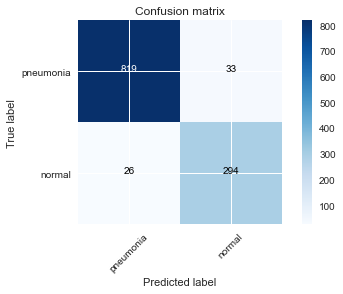

In [32]:
# Compute confusion matrix.
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
# Plot confusion matrix.
plot_confusion_matrix(cnf_matrix, classes=['pneumonia','normal'],normalize= False,  title='Confusion matrix')

**DEEP LEARNING**

**Modeling**

I use the input shape and a batch size of 32 which is a good compromise between accuracy and response time. The activation function and the optimizer will be search trhough a fine tuning process as well as the option to augment the data. I chose the binary crossentropy loss function because it is a common choice for classification, and the accuracy metric because it is easy to interpret.

I will compose a neural network in 5 convolutional blocks with convolutional layer, max-pooling and batch-normalization. On top of it you find a flatten layer followed by two dense layers, and in between a dropout layer to reduce over-fitting. 

In [36]:
input_shape = (150,150,3)

In [37]:
def modeling(activation_f=None, optimizer_f=None, input_shape_img=None):
    '''
    This function creates the model based on different parameters, complile and save it.
    '''
    model = Sequential()
    
    #1st block
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = activation_f , input_shape = input_shape_img))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    #2nd block
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = activation_f))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    #3rd block
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = activation_f))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    #4th block
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = activation_f))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    #5th block
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = activation_f))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Flatten())
    model.add(Dense(units = 128 , activation = activation_f))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid')) 

    model.compile(optimizer=optimizer_f, loss='binary_crossentropy', metrics=['accuracy']) # compiling ##'MeanSquaredError'
    
    model.save('./data/model.h5') # saving
    
    return model

In [38]:
# just running a test
model = modeling('relu', 'adam', input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 64)       

**TRAINING**

**Fine tuning optimizer and activation function**

In [39]:
# Looping through different optimizers and activation functions to find the best score.
input_shape_img = (150,150,3)
activation_functions = ['relu', 'sigmoid', 'tanh']
optimizers = ['adam', 'rmsprop']
# best_score = 0
best_accuracy = 0
best_optimizer = None
best_activation_function = None

for activation_function in activation_functions:
    for optimizer_function in optimizers:
        modeling(activation_function, optimizer_function, input_shape) # model function
        model = load_model('./data/model.h5') # load model
        history = model.fit( 
                            X_train, y_train,
                            batch_size=32, #1 epoch (default)
                            validation_split=0.2,
                            verbose=1) # validation set
        if history.history['accuracy'][0] > best_accuracy:
            best_accuracy = history.history['accuracy'][0]
            best_optimizer = optimizer_function
            best_activation_function = activation_function
            model.save('./data/best_model.h5')

print('The best optimizer is {}, the best activation function is {}, for an accuracy of {:.2f}%'
     .format(optimizer_function, best_activation_function, best_accuracy*100))

The best optimizer is rmsprop, the best activation function is relu, for an accuracy of 90.55%


**We have estimated the best activation function and the best optimizer, which we'll use in the next fine tuning steps.**

**FINE TUNING FEATURES**

**Reduce bias**

In [40]:
# Finding the proportion between scans with and without pneumonia, and calculating the weights to counter-balance the bias during training.

count_normal = len(y_train[y_train==0]) 
count_pneumonia = len(y_train[y_train==1])
initial_bias = np.log([count_pneumonia / count_normal]) 
print("Initial bias: {:.4f}".format(initial_bias[0]))

train_img_count = len(y_train)
weight_for_0 = (1 / count_normal) * train_img_count / 2.0
weight_for_1 = (1 / count_pneumonia) * train_img_count / 2.0

class_weights = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 0.9964
Weight for class 0: 1.85
Weight for class 1: 0.68


In [41]:
# Training the model adding class weights

model = load_model('./data/best_model.h5')
history = model.fit(
                    X_train,y_train,
                    batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weights,
                    verbose=1) # 1 epoch (default)
if history.history['accuracy'][0] > best_accuracy:
    best_accuracy = history.history['accuracy'][0]
    print('Accuracy improved: ', best_accuracy*100)
else:
    print('Adding class weights didn\'t improve the accuracy')

118/118 [==============================] - 228s 2s/step - loss: 0.1931 - accuracy: 0.9279 - val_loss: 7.7320 - val_accuracy: 0.7279
Accuracy improved:  92.79423356056213


**It looks like adding the weights improved our model.**

**TRAINING THE FINALLY OPTIMIZED MODEL (10 epochs)**

**Note about performance:** becasue training over different epochs may become too intensive for my hardware I run the model under IBM Watson Studio where I can setup a Notebook with a proper choice of runtime (more CPUs, more memory). To implement the Notebook I just need to upload the X and Y arrays as file in the Object Cloud store and use them instead of parsing the images with Keras.

**Data augmentation**

Data augmentation means increasing the samples by means of adding scans from different perspectives, which bring the model closer to reality.

In [42]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

**Callbacks**

Before training the model is useful to define one or more callbacks:

1. ModelCheckpoint: save a copy of the best performing model when an epoch that improves the metrics ends.

2. EarlyStopping: stop training when the difference between training and validation error starts to increase, instead of decreasing (overfitting).

Optimizing the learning rate:

Learning rate is a descent step which the optimizing algorithms take in order to converge to a local optimum. The learning rate should not be too high to take very large steps nor it should be too small which would not alter the weights and biases. The ReduceLRonPlateau monitors the learning rate and if no improvement is seen for a (patience) number of epochs then the learning rate is reduced by a factor specified as one of the parameters.

In [47]:
# Initializing callbacks
path = f'./data/model.h5'

# Saves the model in-between epochs when there is an improvement in val_loss
checkpoint = ModelCheckpoint(path,
                                monitor='val_loss',
                                mode="min",
                                save_best_only = True,
                                verbose=1)

# Stops training the model when no improvement in val_loss is observed after set patience
earlystop = EarlyStopping(monitor = 'val_loss', 
                              min_delta = 0, 
                              patience = 4,
                              verbose = 1,
                              restore_best_weights = True)

# Monitors val_accuracy for a set 'patience', then the learning rate is reduced by a factor specified in the parameters
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', ## val_accuracy
                              patience = 2,
                              verbose=1,
                              factor=0.3, # reduction
                              min_lr=0.000001)

# callbacks pipeline
callbacks_pipeline = [checkpoint, earlystop, reduce_lr]

In [48]:
# Modelling and training using the chosen optimizer, activation function, callbacks and no data augmentation.
filt = np.random.rand(len(X_train))

model = load_model('./data/best_model.h5')
history = model.fit(
#                 X_train,y_train,
                datagen.flow(X_train[filt < 0.8],y_train[filt < 0.8], batch_size = 32),
                batch_size=32,
#                 validation_split=0.2,
                class_weight=class_weights,
                validation_data=datagen.flow(X_train[filt > 0.8], y_train[filt > 0.8]), 
                epochs=10, #10 epochs
                callbacks=callbacks_pipeline,
                verbose=1)

Epoch 1/10
118/118 [==============================] - 264s 2s/step - loss: 0.3284 - accuracy: 0.8612 - val_loss: 7.3711 - val_accuracy: 0.7440

Epoch 00001: val_loss improved from inf to 7.37108, saving model to ./data/model.h5
Epoch 2/10
118/118 [==============================] - 227s 2s/step - loss: 0.2898 - accuracy: 0.8869 - val_loss: 2.9889 - val_accuracy: 0.7440

Epoch 00002: val_loss improved from 7.37108 to 2.98889, saving model to ./data/model.h5
Epoch 3/10
118/118 [==============================] - 214s 2s/step - loss: 0.2511 - accuracy: 0.9020 - val_loss: 1.2323 - val_accuracy: 0.7484

Epoch 00003: val_loss improved from 2.98889 to 1.23233, saving model to ./data/model.h5
Epoch 4/10
118/118 [==============================] - 220s 2s/step - loss: 0.2340 - accuracy: 0.9120 - val_loss: 0.2320 - val_accuracy: 0.9198

Epoch 00004: val_loss improved from 1.23233 to 0.23202, saving model to ./data/model.h5
Epoch 5/10
118/118 [==============================] - 249s 2s/step - loss: 0

In [49]:
# Predicting..
preds = model.predict(X_test)

**Evaluating against the test set**

In [50]:
#Model metrics
score = model.evaluate(X_test, y_test, batch_size=32) # test set
print('Test loss: {:.2f}%'.format(score[0]*100))
print('Test accuracy: {:.2f}%'.format(score[1]*100))

37/37 [==============================] - 17s 450ms/step - loss: 0.1362 - accuracy: 0.9565
Test loss: 13.62%
Test accuracy: 95.65%


**We reached an accuracy score which improves the Logistics Regression**

In [51]:
# Plotting the validation curves.

def plot_validation_curves(result):
    '''
    This function plots the validation curves.
    '''
    result = pd.DataFrame(result)
    fig, axs = plt.subplots(1,2)
    result[['loss','val_loss']].plot(figsize=(10, 3),ax=axs[0])
    axs[0].set_title('Train vs validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    result[['accuracy','val_accuracy']].plot(figsize=(10, 3),ax=axs[1])
    axs[1].set_title('Train vs validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')

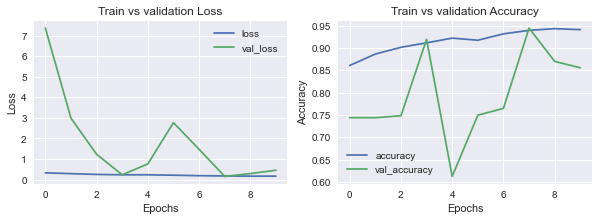

In [52]:
plot_validation_curves(history.history)

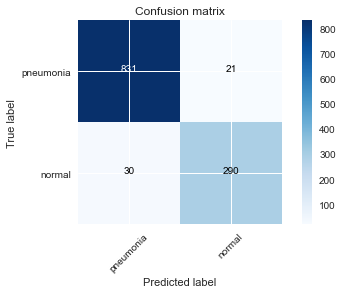

In [53]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, np.round(preds), labels=[1,0])
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['pneumonia','normal'],normalize= False,  title='Confusion matrix')

This image is 98.88% pneumonia and 1.12% normal.


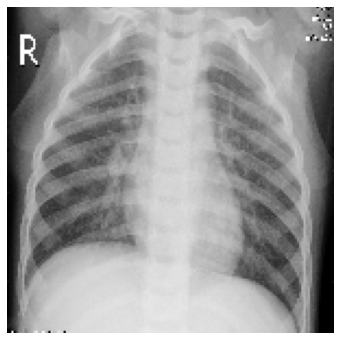

In [54]:
# Showing a randomly selected scan along with the probability that it's a pneumonia vs normal.

random_num = np.random.randint(0,len(X_test))
pred = model.predict(X_test[random_num:random_num+1,:,:,:])
score = pred[0]

print('This image is {:.2f}% pneumonia and {:.2f}% normal.'.format(100 * score[0],100*(1-score[0])))
plt.figure(figsize=(12,6))
plt.imshow(X_test[random_num,:,:,:])
plt.grid(False)
plt.axis('off')
plt.show()

**THANK YOU**